# Model Interpretability using GradCAM

<center><img src = "https://learnopencv.com/wp-content/uploads/2023/12/GradCAM-examples.png" width=600></center>

In [1]:
import os
import random
import requests
from zipfile import ZipFile
from collections import OrderedDict

import numpy as np
import pandas as pd
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as T, models
from torchvision.models import EfficientNet_V2_S_Weights

import matplotlib.pyplot as plt
from matplotlib import colormaps

from torchvision.models.feature_extraction import create_feature_extractor

In [2]:
random.seed(64)
torch.set_float32_matmul_precision('high')

## Download and Extract Data

In [3]:
def download_and_unzip(url, save_path):

    print("Downloading and extracting assets...", end="")
    file = requests.get(url)
    open(save_path, "wb").write(file.content)

    try:
        # Extract zipfile.
        if save_path.endswith(".zip"):
            with ZipFile(save_path) as zip:
                zip.extractall(os.path.split(save_path)[0])

        print("Done")
    except:
        print("Invalid file")

- Download the **dataset**.
- Download the **model checkpoints** and validation image filepaths used during data prepartion.

In [4]:
DATASET_URL = f"https://www.dropbox.com/scl/fi/8xh03beb47jbaug5sxz44/brain_mri.zip?rlkey=c05xd8dyuzz8ev5scacwcnlzt&dl=1"
DATA_ZIP_FILE = f"brain_mri.zip"
DATASET_DIR = f"data"
DATASET_ZIP_PATH = f"{DATA_ZIP_FILE}.zip"

MODEL_LOGS_URL = f"https://www.dropbox.com/scl/fi/zzu1z0pgexar5ttyhrqfg/EffNet-FT-Logs.zip?rlkey=4a8n128wes7yn8dgb1xsxthxg&dl=1"
MODEL_LOGS_DIR = f"EffNet-FT-Logs"
MODEL_LOGS_ZIP_PATH = f"{MODEL_LOGS_DIR}.zip"

# Download if dataset does not exists.
if not os.path.exists(DATASET_DIR):
    download_and_unzip(DATASET_URL, DATASET_ZIP_PATH)
    os.remove(DATASET_ZIP_PATH)


# Download if Model Checkpoints and Logs does not exist.
if not os.path.exists(MODEL_LOGS_DIR):
    download_and_unzip(MODEL_LOGS_URL, MODEL_LOGS_ZIP_PATH)
    os.remove(MODEL_LOGS_ZIP_PATH)

#### Read the CSV and Maintain ID-to-Class Mapping

In [5]:
data_frame = pd.read_csv("validation_samples.csv")
idx_to_cls_names = {0: "glioma", 1: "meningioma", 2: "notumor", 3: "pituitary"}

# Obtain the filepaths and ground truth targets
image_files, targets = data_frame["Filename"].tolist(), data_frame["Target"].tolist()

## Image Preprocess Transforms

In [6]:
def img_preprocess_transforms():
    preprocess = EfficientNet_V2_S_Weights.IMAGENET1K_V1.transforms()
    return preprocess

## Load Fine-tuned EfficientNetV2 Small Model from Model Checkpoint

We should not disable the `requires_grad` for the parameters from any of the layers; since we wish to perform GradCAM from any intermediate layers.

In [8]:
def load_effnet_v2_s(ckpt_path, num_classes=4):

    # Load pytorch-lighning checkpoint dict after fine-tuning.
    pl_ckpt_dict = torch.load(ckpt_path, map_location="cpu")

    # Create new checkpoint state dict to transfer model weights.
    new_state_dict = OrderedDict()

    # ----------------------- Model Defintion ----------------------------
    # --------------------------------------------------------------------
    # Load EffNetV2_S model definition.
    effnet_v2s = models.efficientnet_v2_s(weights=None)

    # obtain output channels of the last conv layer
    # in the feature extractor.
    last_conv_out_channels = effnet_v2s.classifier[-1].in_features

    # Update the classifier block.
    effnet_v2s.classifier[-1] = nn.Linear(in_features=last_conv_out_channels,
                                          out_features=num_classes)

    # --------------------------------------------------------------------

    # Transfer fine-tuned weights to the model defined above
    # by mapping them with the appropriate parameter names.

    # This is done by simply stripping the "model." prefix
    # parameter names from the lightning model's state_dict.

    for k,v in pl_ckpt_dict["state_dict"].items():
        new_state_dict[k.replace("model.", "")] = v

    # Load the state_dict of new_state_dict to effnet_v2s.
    effnet_v2s.load_state_dict(new_state_dict)

    return effnet_v2s

### Load Model

In [9]:
model_ckpt_path = "EffNet-FT-Logs/EffNet-FT-Logs/version_0/checkpoints/effnetv2_s_019.ckpt"

effnet_ft_model = load_effnet_v2_s(model_ckpt_path, num_classes=4)

## Process Image before Forward Pass

In [10]:
# Function to read, preprocess, and return an image tensor.
def process_image(img_path):

    # Read image file from disk.
    rgb_image = Image.open(img_path).convert("RGB")

    # Convert the PIL image to a NumPy array.
    image_np = np.array(rgb_image)

    # Obtain the appropriate transforms for forward pass.
    preprocess_transforms = img_preprocess_transforms()

    # Apply the transforms above to the PIL image.
    image_trans = preprocess_transforms(rgb_image)

    return image_np, image_trans

The `get_model_outputs` forward passes the image tensor through the network and returns the logits from the final classifier as well as the outputs from the feature maps of the specified layer.

To access the outputs from the intermediate layers of any PyTorch model, we can use the [create_feature_extractor](https://pytorch.org/vision/main/generated/torchvision.models.feature_extraction.create_feature_extractor.html) utility that outputs a dictionary with user-specified keys strings and requested output tensors as values.

In [11]:
def get_model_outputs(model, img_tensor, layer_name):

    model.eval()

    return_nodes = {
                    layer_name: "last_conv_op",
                    "classifier": "out_classifier"
                   }

    effnet_body = create_feature_extractor(model, return_nodes=return_nodes)

    output_nodes_dict = effnet_body(img_tensor)

    last_conv_layer_output = output_nodes_dict["last_conv_op"]
    preds_classifier       = output_nodes_dict["out_classifier"]

    return last_conv_layer_output, preds_classifier

The function below implements the Grad-CAM processing to produce a Grad-CAM heatmap. The heatmap will be generated based on the top-scoring predicted class.

We took advantage of the [register_hook](https://pytorch.org/docs/stable/generated/torch.Tensor.register_hook.html) utility to keep track of the gradients for the concerned tensor.

In [12]:
def make_gradcam_heatmap(trans_img, model, last_layer_name):

    # Obtain the outputs from the last layer and the logits from the final classifier.
    last_conv_layer_output, preds = get_model_outputs(model, trans_img, last_layer_name)

    # Store the gradients of the concerned tensor.
    layer_grads = []

    # Register a backward hook for obtaining the gradients with respect to last_conv_layer_output.
    hook = last_conv_layer_output.register_hook(lambda grad: layer_grads.append(grad.detach()))

    # Obtain the predicted class with max score.
    pred_index = torch.argmax(preds.squeeze(0))

    class_channel = preds[:, pred_index]

    # Compute the gradient of the output neuron (top predicted or chosen) with
    # respect to the feature map activations across all the blocks of the EfficientNet model.

    # However, we are only concerned about the gradients with respect to last_conv_layer_output
    # and hence we have its hook registered to store the gradients accordingly.
    # Each gradient (map) has the same (2D) shape as the activation maps.
    class_channel.sum().backward()

    # Perform global average pooling on each gradient map. This is a vector where
    # neach entry is the mean intensity of the corresponding 2D gradient map.
    # These are the alpha values that will be used to weight each activation map.
    pooled_grads = torch.mean(layer_grads[0], (0, 2, 3)) # shape: (H,)

    # Reshape the tensor from [B, C, H, W] to [H, W, C] for matrix multiplication.
    # B = 1; since we are performing GradCAM on a single image.
    conv_op_reshape = last_conv_layer_output[0].permute(1,2,0).detach()

    # Computed the weighted sum of the activation maps using the pooled gradients.
    heatmap = conv_op_reshape @ pooled_grads

    # Normalize the heatmap to the range [0., 1.].
    heatmap = heatmap.clamp(min=0.) / heatmap.max()

    # Remove the registered hooks.
    hook.remove()

    return heatmap.numpy(), int(pred_index.detach())

## Display Heatmap Overlayed on Image

In [13]:
def display_heatmap(image, heatmap, target, pred_cls):

    h, w, _ = image.shape

    # Resize the heatmap to be the same size as the input image so it can be overlayed on the image.
    heatmap = cv2.resize(heatmap, (w, h))

    # Convert the heatmap to RGB and use a "jet" color map so that dark red corresponds to highly
    # activated regions within the image and blue corresponds to regions with less activation.
    heatmap = np.uint8(255 * heatmap)
    cmap = colormaps["jet"]
    colors = cmap(np.arange(256))[:, :3]
    rgb_heatmap = colors[heatmap]

    # Overlay the heatmap on the original input image
    # and clip the array between [0,1]
    final_image = np.clip(rgb_heatmap*0.6 + image/255., 0., 1.)

    images = [image, rgb_heatmap, final_image]

    titles = [f"GT: {idx_to_cls_names[target]}",
              f"Heatmap (Pred: {idx_to_cls_names[pred_cls]})",
              "Overlayed Heatmap"]

    plt.figure(figsize=(21, 18))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(titles[i], fontdict={"size": 18})
        plt.tight_layout()
    plt.show()

## GradCAM Examples

### Specify Layer Name

In [14]:
last_layer_name = "features.7"

### Visualizations

/usr/local/lib/python3.10/dist-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


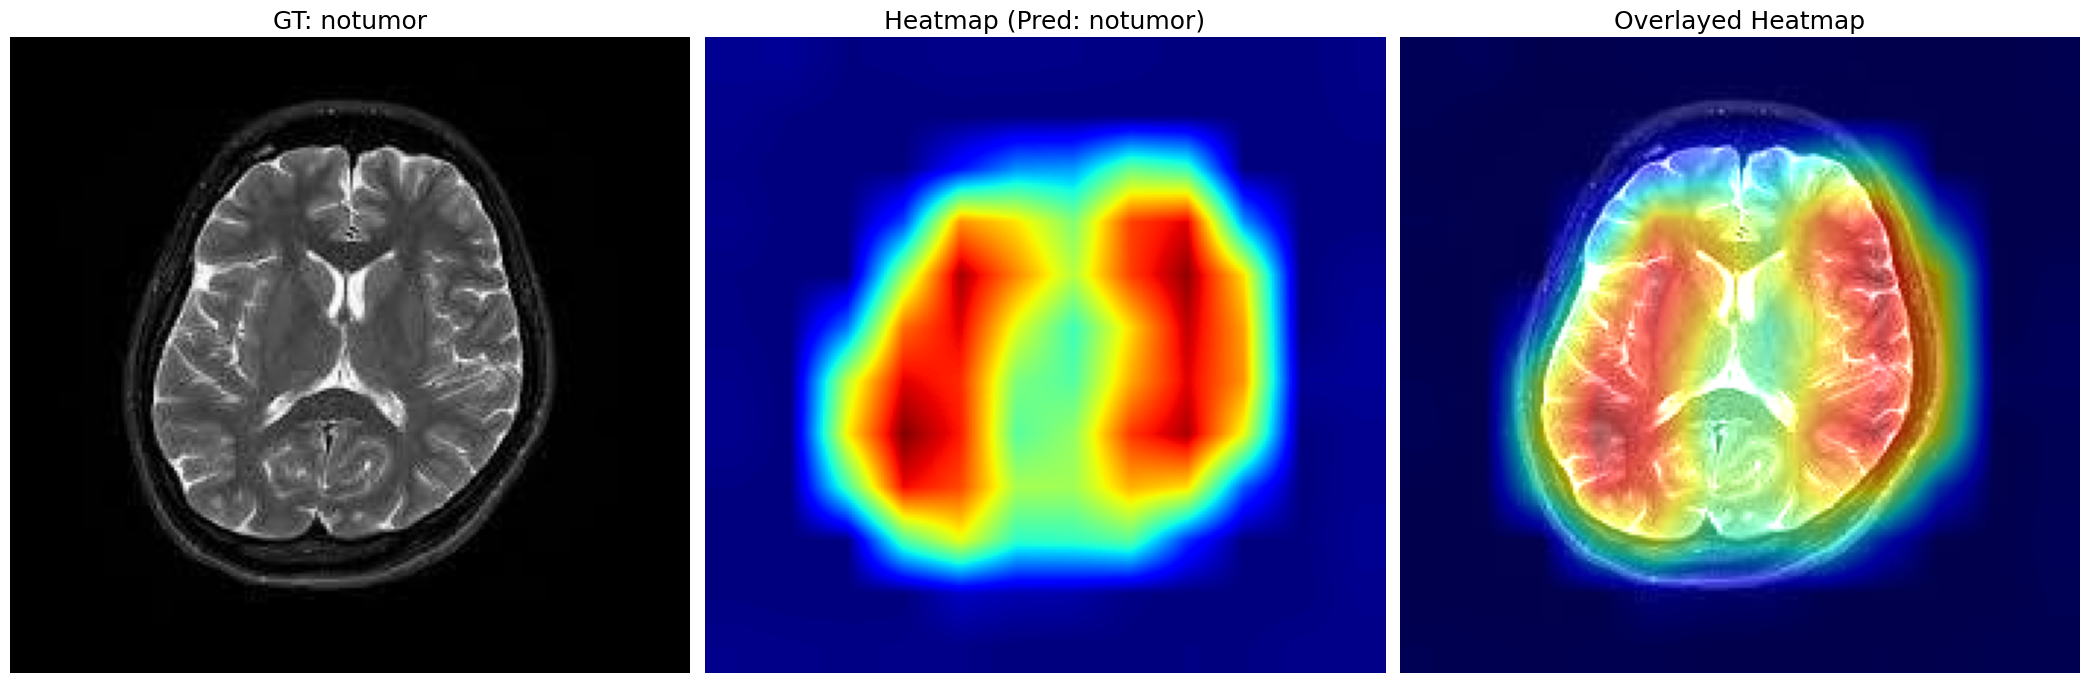

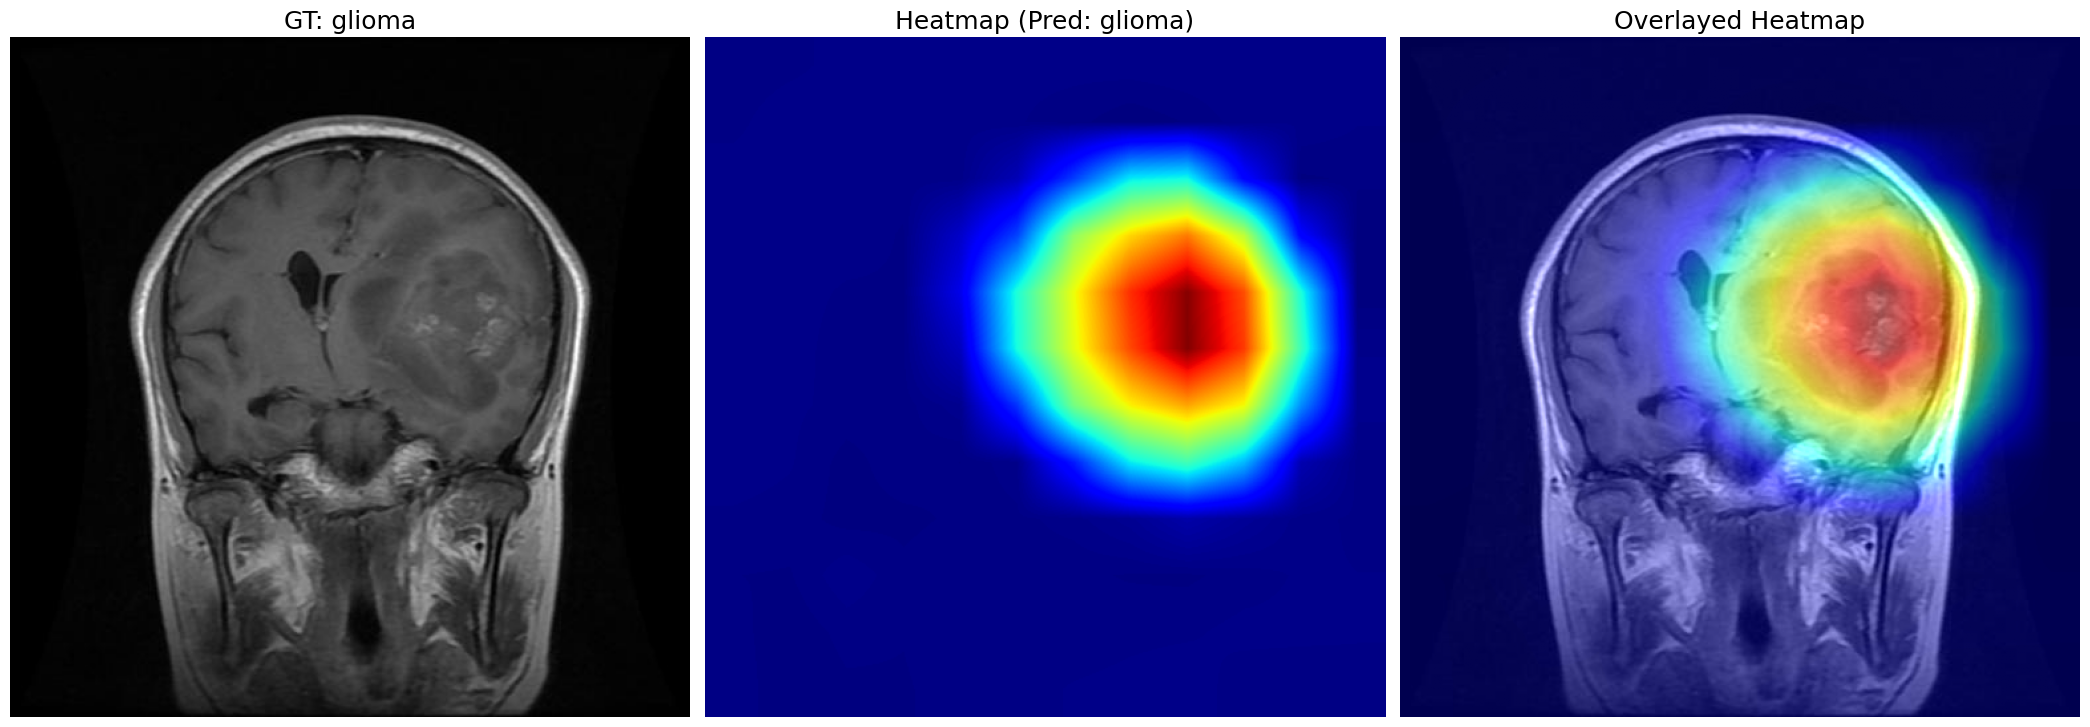

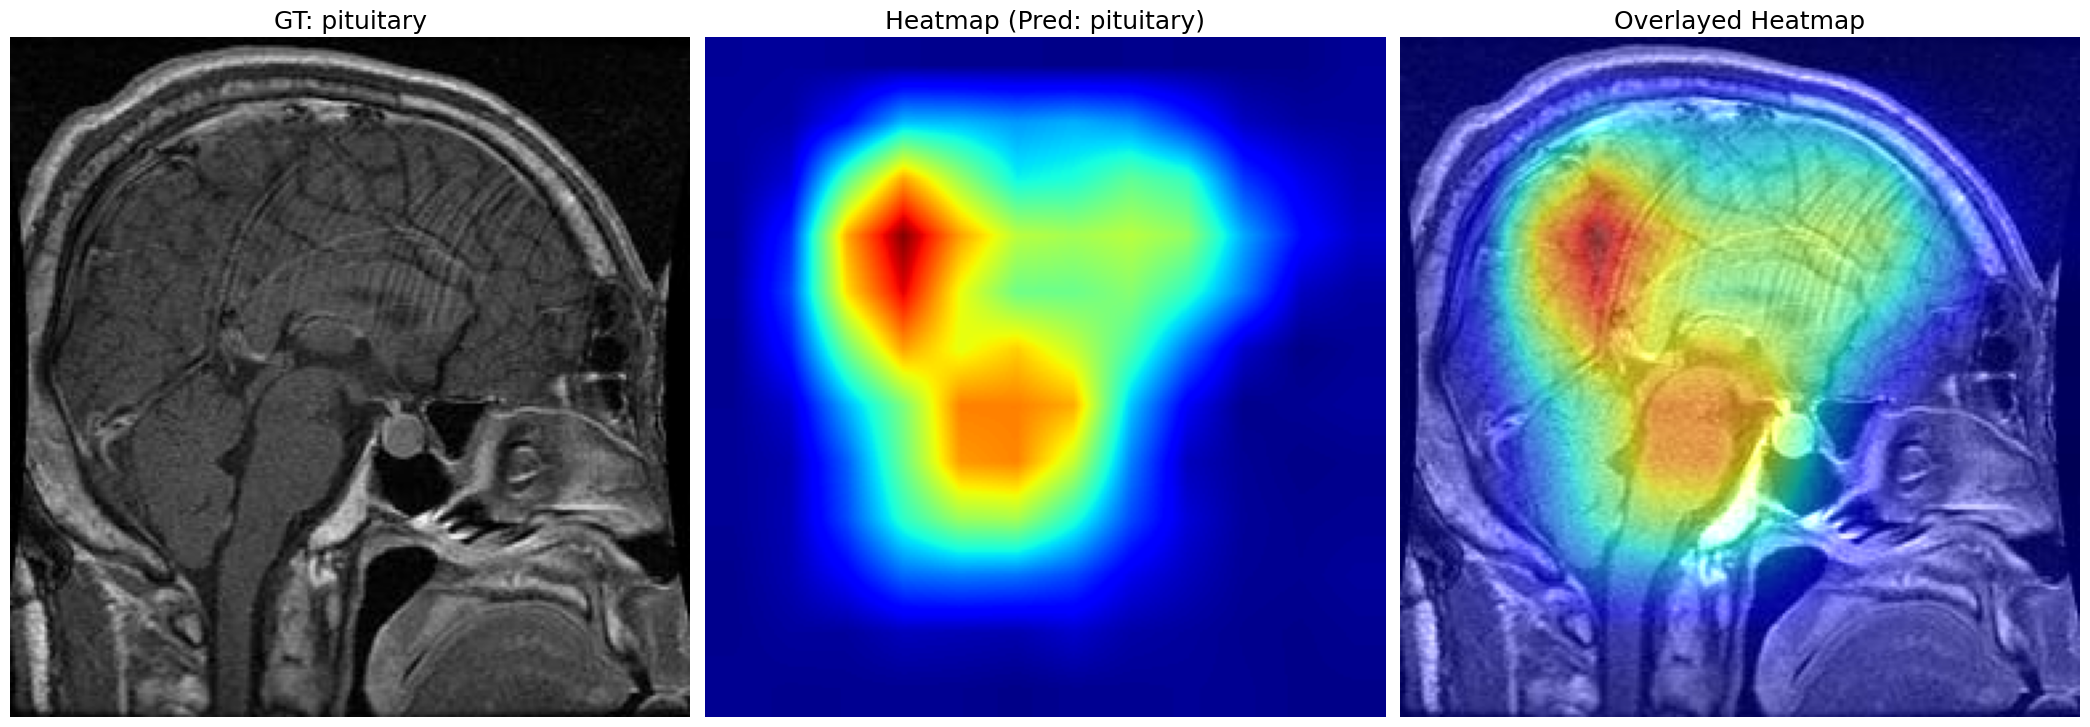

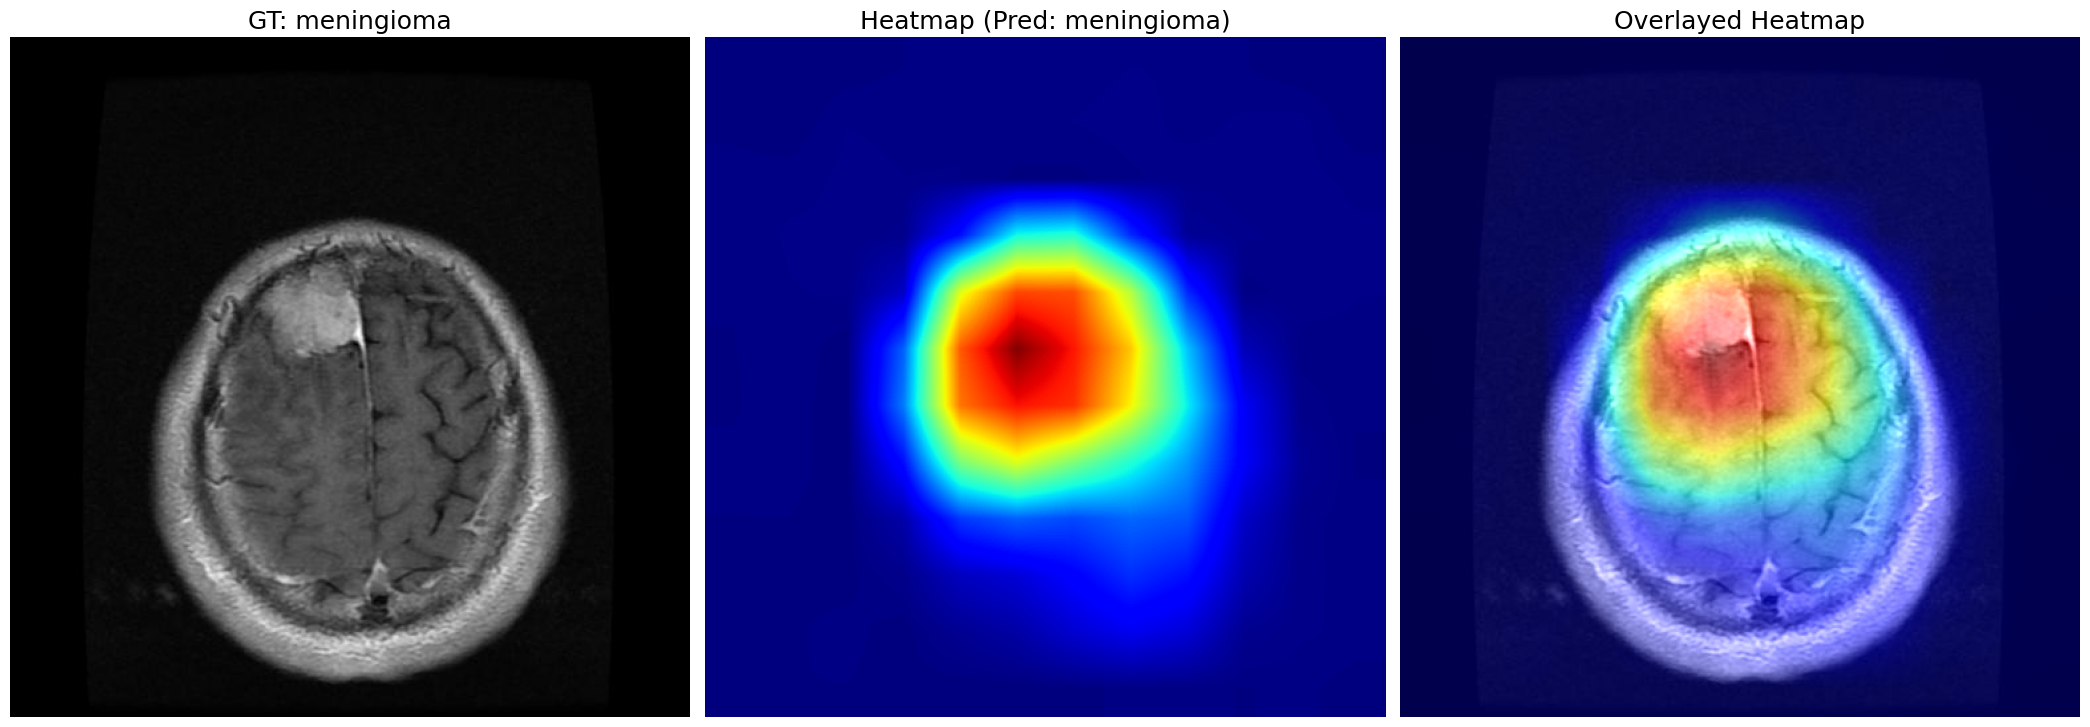

In [15]:
rand_ids = [1, 2, 4, 5]

image_paths = np.take(image_files, rand_ids).tolist()
gt_targets = np.take(targets, rand_ids).tolist()

for img_path, gt in zip(image_paths, gt_targets):
    # Prepare the image with appropriate transforms.
    rgb_image, img_tensor = process_image(img_path)

    # Add a batch dimension to the transformed image tensor.
    image_batch = img_tensor.unsqueeze(0)

    heatmap, pred_cls = make_gradcam_heatmap(image_batch, effnet_ft_model, last_layer_name)

    display_heatmap(rgb_image, heatmap, gt, pred_cls)

### More Visualizations...

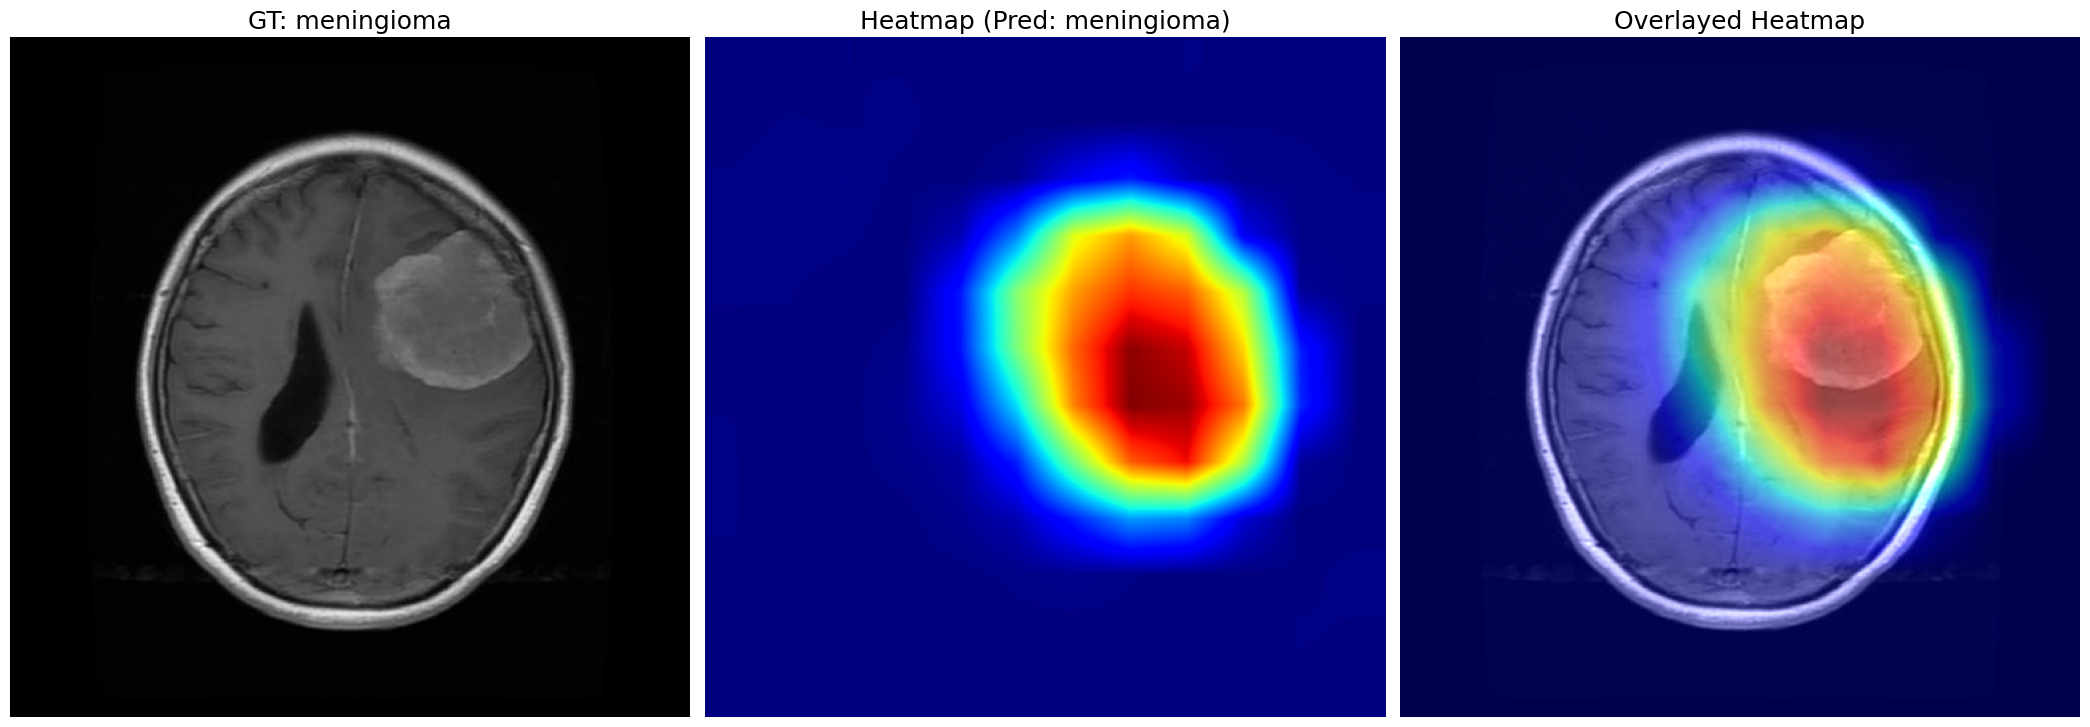

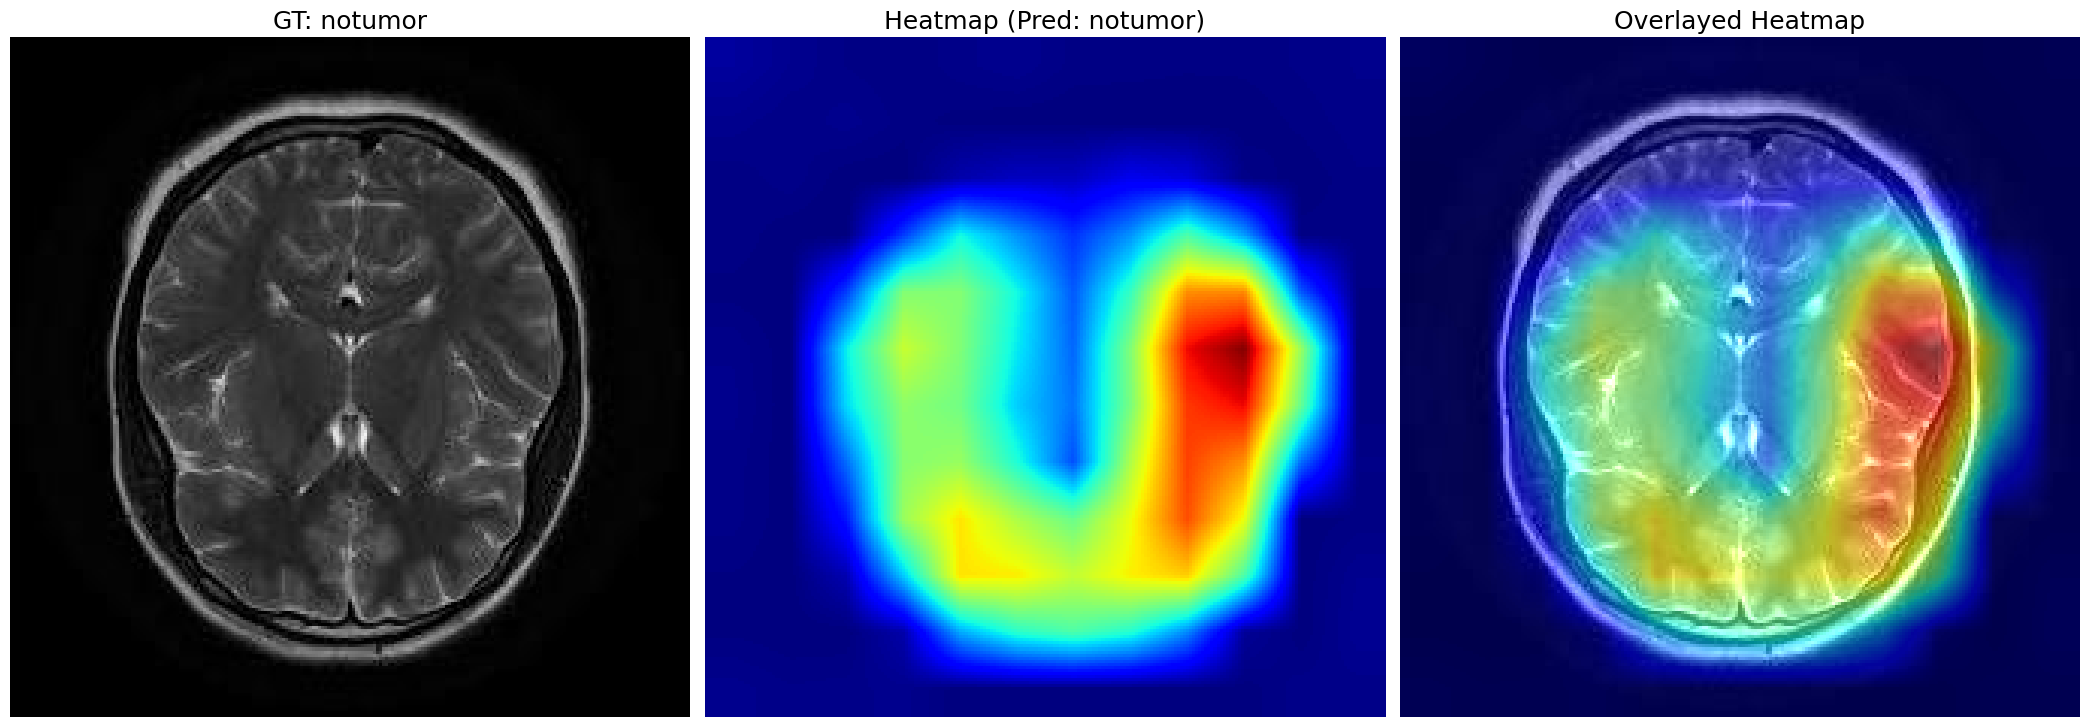

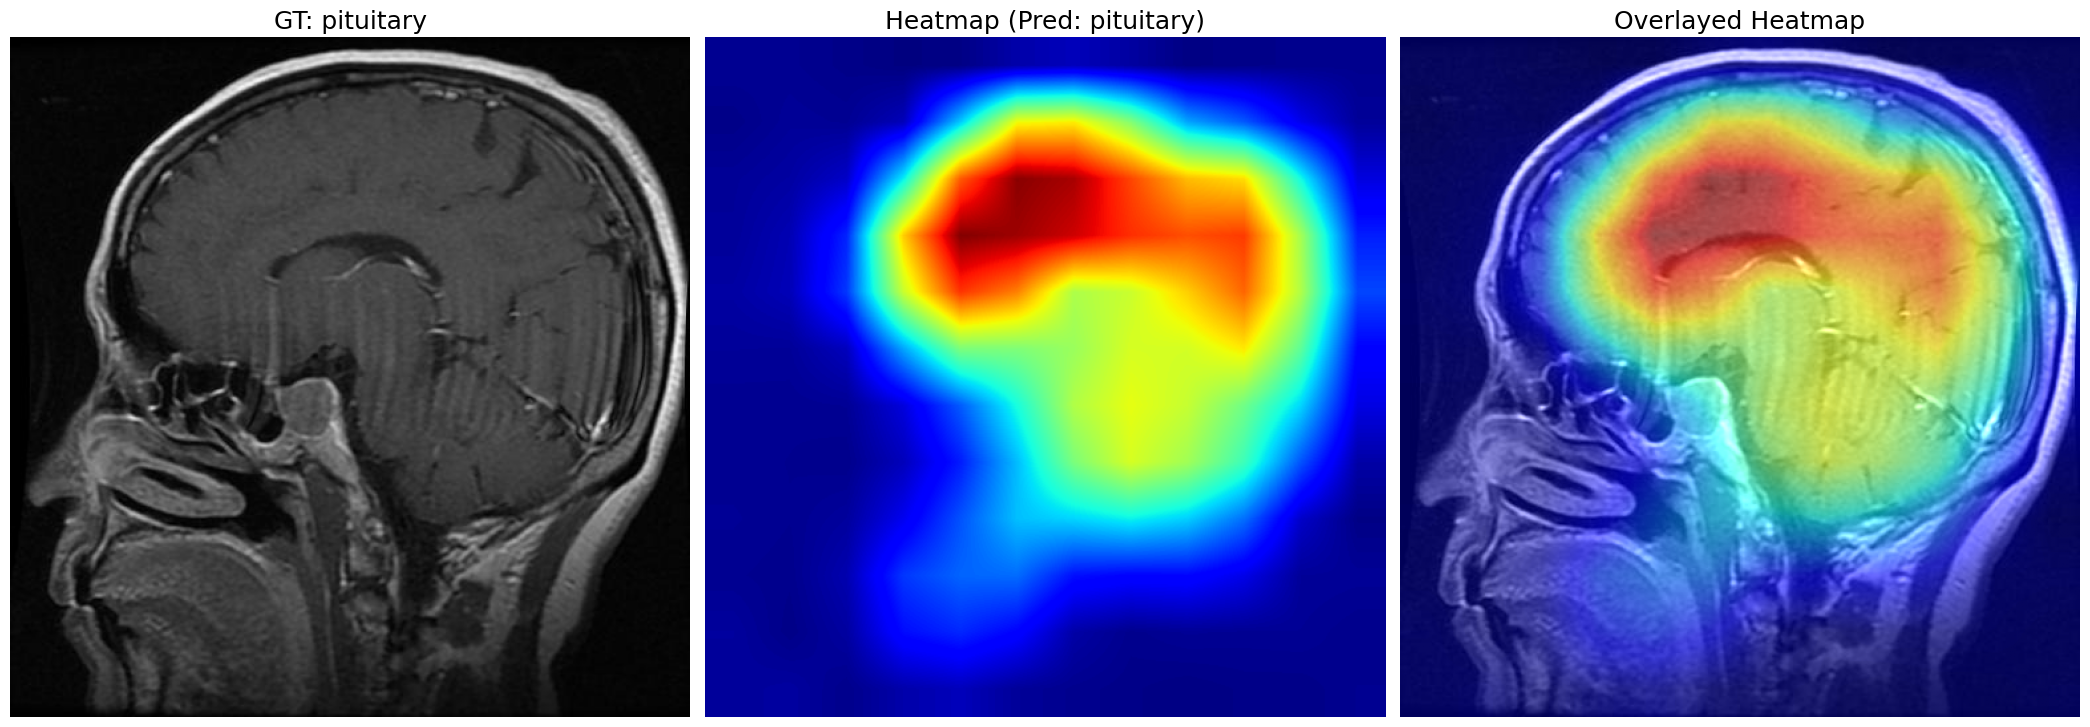

In [16]:
rand_ids = random.sample(range(len(image_files)), k=3)

image_paths = np.take(image_files, rand_ids).tolist()
gt_targets = np.take(targets, rand_ids).tolist()

for img_path, gt in zip(image_paths, gt_targets):
    # Prepare the image with appropriate transforms.
    rgb_image, img_tensor = process_image(img_path)

    # Add a batch dimension to the transformed image tensor.
    image_batch = img_tensor.unsqueeze(0)

    heatmap, pred_cls = make_gradcam_heatmap(image_batch, effnet_ft_model, last_layer_name)

    display_heatmap(rgb_image, heatmap, gt, pred_cls)

### GradCAM from Intermediate Layers from Feature Extractor

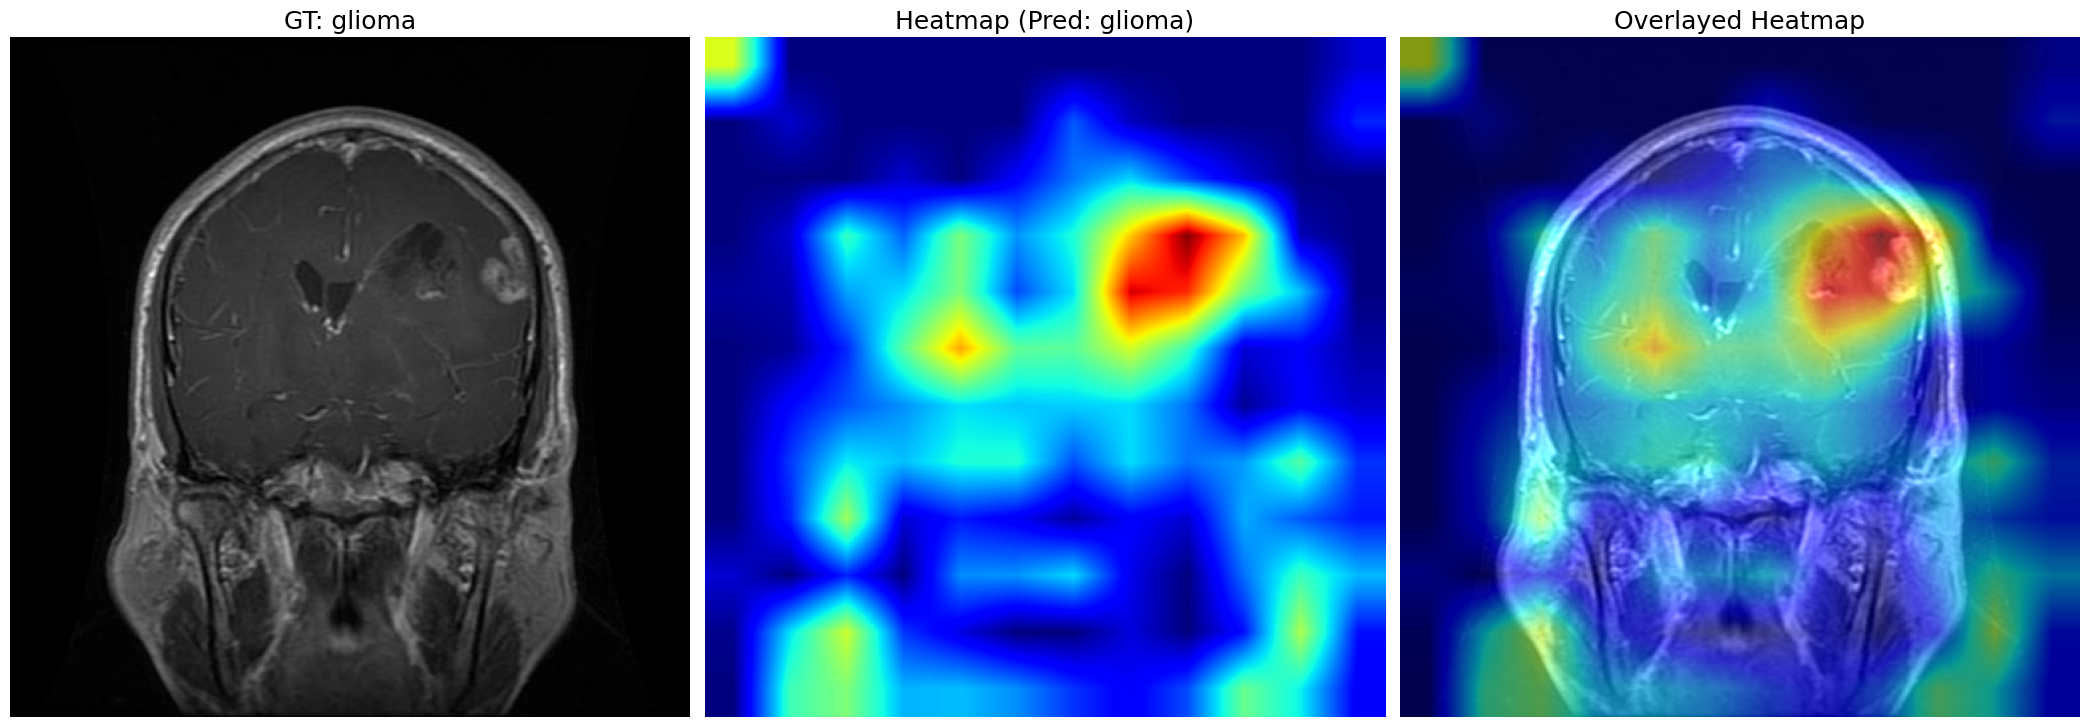

In [17]:
last_layer_name = "features.6.5.add"

random.seed(42)
rand_id = random.choice(range(len(image_files)))

image_path = image_files[rand_id]
gt_target = targets[rand_id]


# Prepare the image with appropriate transforms.
rgb_image, img_tensor = process_image(image_path)

# Add a batch dimension to the transformed image tensor.
image_batch = img_tensor.unsqueeze(0)

heatmap, pred_cls = make_gradcam_heatmap(image_batch, effnet_ft_model, last_layer_name)

display_heatmap(rgb_image, heatmap, gt_target, pred_cls)